# Convolutional Neural Network - Digit Recognition
This notebook focuses on training and using a convolutional neural network for digit recognition.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Plot Settings

# matplotlib
plt.rcParams['figure.figsize'] = 14,6
plt.rcParams.update({'font.size': 16})

# seaborn
sns.set_style('whitegrid')
color_palette = sns.color_palette("husl", 8)
sns.set_palette(color_palette)

## Tensorflow
import tensorflow as tf
from tensorflow import keras

The data that we will be using is the MNIST dataset containing 60,000 28x28 grayscale images of the 10 digits. It also includes a test set of 10,000 additional images.

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

For faster convergence, it is helpful to normalize the image pixels (instead of having pixel values ranging from 0 to 255).

In [3]:
X_train, X_test = X_train/255.0, X_test/255.0

In [4]:
def disp_images(X, y, seed = 69, preds = [], random=True):
    """Displays 16 random images from the dataset X
    """
    # Set seed
    np.random.seed(seed)
    
    # Choose random images
    if random:
        choices = np.random.randint(X.shape[0], size = 16)
    else:
        choices = range(X.shape[0])
    
    # Loop over all choices
    for ix, choice in enumerate(choices):
        plt.subplot(4, 4, ix+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[choice,:,:])
        plt.xlabel(y[choice])
        if len(preds) != 0:
            plt.text(1, -5, '{}'.format(preds[ix]),
                    size=15, color='blue',
                    horizontalalignment='center',
                    verticalalignment='center')
    # Show figure
    plt.tight_layout()
    plt.show()

Let us look at the dataset

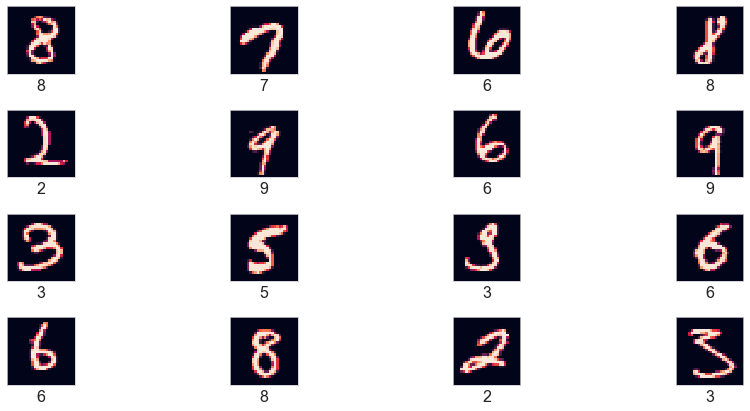

In [5]:
disp_images(X_train,y_train)

## Building the Model

Here is the outline of the model architecture that we intend to build:
- 1 input layer (Convolutional layer)
- 2 pooling layers with 1 convolutional layer in between them
- 1 flattening layer to be able to connect the previous output to a densely connected layer
- 1 densely connected layer to flatten the feature map
- 1 dropout layer to minimize the effect of overfitting
- 1 output layer (densely connected layer with 10 output nodes -- one for each digit)

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
# Use sequential model since the order of the layers is important
model = keras.Sequential()

# Add the input layer (which also serves as a convolutional layer)
model.add(keras.layers.Conv2D(
            filters = 32, # Output layers
            kernel_size = (5,5), # Size of convolution patch
            strides = (1,1), # How convolution patch move
            padding = 'same',
            activation = 'relu',
            input_shape = (28, 28, 1),
            name = 'conv1'
            )
         )

# Add a maxpooling layer to decrease the size of the feature map
model.add(keras.layers.MaxPool2D(
            pool_size = (2,2), # Pooling patch size -> would cause to half the dimension of previous layer
            name = 'pool1'
            )
         )

# Add another convolutional layer
model.add(keras.layers.Conv2D(
            filters = 64,
            kernel_size = (5,5),
            strides = (1,1),
            padding = 'same',
            activation = 'relu',
            name = 'conv2'
            )
         )

# Add another pooling layer
model.add(keras.layers.MaxPool2D(
            pool_size = (2,2),
            name = 'pool2'
            )
         )

# Add a flattening layer to be able to connect the previous output to a densely connected layer
model.add(keras.layers.Flatten())

# Add a dense layer
model.add(keras.layers.Dense(
            units = 1024,
            activation = 'relu',
            name = 'dense1'
            )
         )

# Add dropout layer
model.add(keras.layers.Dropout(
             rate=0.5 
            )
         )

# Add output layer (dense)
model.add(keras.layers.Dense(
            units = 10, # corresponding to the 10 digits
            activation = 'softmax', # Use softmax to distribute the probability to each of the 10 output units
            name ='dense2'
            )
         )

Sanity check

In [8]:
model.compute_output_shape(input_shape = (None, 28, 28,1))

TensorShape([None, 10])

For multiclass classification with <i>integer</i> labels, the appropriate loss function would be the <i>SparseCategoricalCrossentropy</i> loss function

#### Building and compiling the model

In [9]:
# Set seed for reproducibility
tf.random.set_seed(69)

# Build the model
model.build(input_shape = (None, X_train.shape[1], X_train.shape[2], 1)) #Grayscale

# Compile
model.compile(optimizer = keras.optimizers.Adam(),# Adam is suited for non convex problems
             loss = keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy']) 

Fit the model using our training set and validating it over our test sets. Before we can use the training set and the test set, we must first reshape it to account for the 4th dimension (the color channel).

In [10]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

Now let us take a subset of X_train to act as our validation set

In [11]:
# Get 10,000 out of the 60,000 to become the validation set
X_train_val = X_train[-10000:,:,:,:]
y_train_val = y_train[-10000:]
# Recreate X_train and y_train (overwrite)
X_train = X_train[:-10000,:,:,:]
y_train = y_train[:-10000]

In [12]:
print(X_train.shape, X_train_val.shape)
print(y_train.shape, y_train_val.shape)

(50000, 28, 28, 1) (10000, 28, 28, 1)
(50000,) (10000,)


In [13]:
history = model.fit(X_train, y_train, epochs = 10,
                   validation_data=(X_train_val,y_train_val), batch_size = 32
                   )

Epoch 1/10
1563/1563 [==============================] - 100s 64ms/step - loss: 0.1258 - accuracy: 0.9603 - val_loss: 0.0511 - val_accuracy: 0.9851
Epoch 2/10
1563/1563 [==============================] - 95s 61ms/step - loss: 0.0437 - accuracy: 0.9865 - val_loss: 0.0451 - val_accuracy: 0.9877
Epoch 3/10
1563/1563 [==============================] - 91s 58ms/step - loss: 0.0318 - accuracy: 0.9899 - val_loss: 0.0389 - val_accuracy: 0.9904
Epoch 4/10
1563/1563 [==============================] - 91s 58ms/step - loss: 0.0222 - accuracy: 0.9929 - val_loss: 0.0437 - val_accuracy: 0.9890
Epoch 5/10
1563/1563 [==============================] - 92s 59ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0458 - val_accuracy: 0.9895
Epoch 6/10
1563/1563 [==============================] - 91s 58ms/step - loss: 0.0164 - accuracy: 0.9949 - val_loss: 0.0354 - val_accuracy: 0.9914
Epoch 7/10
1563/1563 [==============================] - 91s 59ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.0369 

In [14]:
def learning_curve(hist):
    """Creates two plots. One is the loss vs epoch graph, and the other one
    is the accuracy vs epoch graph
    """
    # Obtain range of x values
    x = range(len(hist['loss']))
    
    # Create dataframes
    for_plot_df_loss = pd.DataFrame({'Epoch':x,
                               'Loss':hist['loss'],
                                'Validation Loss':hist['val_loss']})
    
    for_plot_df_acc = pd.DataFrame({'Epoch':x,
                                    'Accuracy':hist['accuracy'],
                                    'Validation Accuracy':hist['val_accuracy']})
    
    # Initialize figure
    fig, ax = plt.subplots(1,2)
    
    # Plot loss
    sns.lineplot(x='Epoch',
                y='value',
                hue='variable',
                style='variable',
                data=pd.melt(for_plot_df_loss, ['Epoch']),
                ax=ax[0],
                lw=3)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    
    # Plot Accuracy
    sns.lineplot(x='Epoch',
                y='value',
                hue='variable',
                style='variable',
                data=pd.melt(for_plot_df_acc, ['Epoch']),
                ax = ax[1],
                lw= 3)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    
    plt.legend(loc='best')
    plt.show()

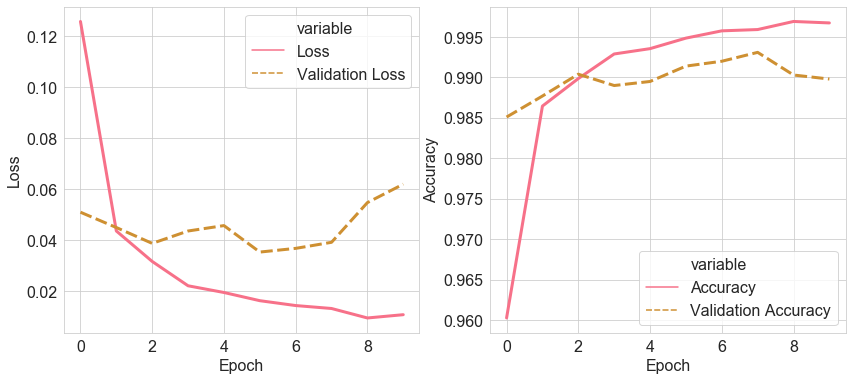

In [15]:
learning_curve(history.history)

Now let us test it on images that the model hasn't seen

In [16]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

313/313 - 3s - loss: 0.0438 - accuracy: 0.9909


Let us visualize the model's prediction

In [17]:
for_prediction = X_test[:16,:,:,:]
preds = np.argmax(model.predict(for_prediction),axis=1)

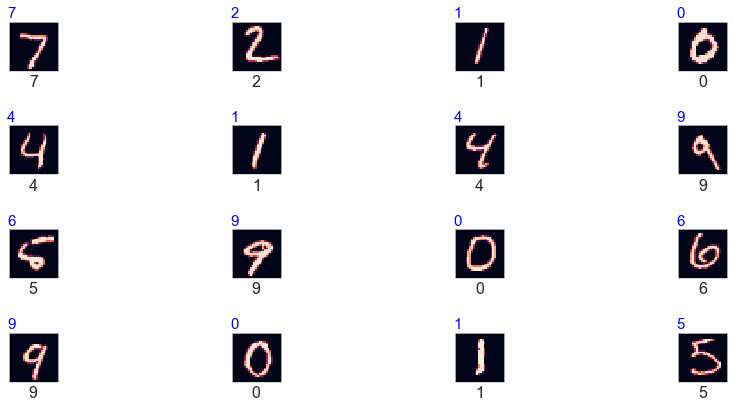

In [18]:
disp_images(X = for_prediction[:,:,:,0],
            y = y_test[:16],
           preds =preds,
           random=False)